# Option Pricing Surace

## Table of Contents
* [1)Benchmark](#first-bullet)
* [2) LSM](#second-bullet)
* [3) Dynamic Chebyshev](#third-bullet)
* [4) Error Surface](#fourth-bullet)

## Setup

In [108]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import os

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
from DC import DynamicChebyshev
from LSM import MonteCarloOptionPricing
from FD import AmericanPutFiniteDifference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Parameter inputs
S0 = 100  # current stock price
r = 0.03  # risk-free rate
K = 100.   # strike price
λ = 0.4 # intensity rate of the Poisson process
dim = 100_000  # number of simulation paths
n = 252  # number of exercise rights per year
n_chebyshev_pol = 100 # degree of chebyshev polynomials
seed = 15_001  # random seed for reproducibility
use_AV = True  # antithetic variates
poly_degree = 3  # polynomial degree for LSM regression
M = 1_000 # number of price steps for Finite Differnece
N = 40_000 # number of time steps for Finite Difference 
σ = 0.25 # volatiltiy parameter in diffusion term

In [3]:
# Define maturities and strikes
maturities = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 15/12, 18/12, 2, 30/12, 3, 4])
strikes = np.arange(0.8 * S0, 1.21 * S0, 0.05 * S0)

## 1) Benchmark <a class="anchor" id="first-bullet"></a>

In [4]:
# Lists to store results
prices_fd = []
maturity_list_fd = []
strike_list_fd = []

In [5]:
# Iterate over each maturity and strike combination
for T in maturities:
    for K in strikes:
        Implicit_Finite_Difference = AmericanPutFiniteDifference(K, r, M)
        FD = Implicit_Finite_Difference.implicit_FD(S0, σ, T, N)
        # Store the results
        prices_fd.append(FD)
        maturity_list_fd.append(T)
        strike_list_fd.append(K)
        # Print
        print(f'K/T: {K}/{T}, F.D.: {FD:.4f}')

K/T: 80.0/0.08333333333333333, F.D.: 0.0016
K/T: 85.0/0.08333333333333333, F.D.: 0.0254
K/T: 90.0/0.08333333333333333, F.D.: 0.2034
K/T: 95.0/0.08333333333333333, F.D.: 0.9323
K/T: 100.0/0.08333333333333333, F.D.: 2.7672
K/T: 105.0/0.08333333333333333, F.D.: 5.9470
K/T: 110.0/0.08333333333333333, F.D.: 10.1848
K/T: 115.0/0.08333333333333333, F.D.: 15.0012
K/T: 120.0/0.08333333333333333, F.D.: 20.0000
K/T: 80.0/0.16666666666666666, F.D.: 0.0403
K/T: 85.0/0.16666666666666666, F.D.: 0.1985
K/T: 90.0/0.16666666666666666, F.D.: 0.6910
K/T: 95.0/0.16666666666666666, F.D.: 1.8213
K/T: 100.0/0.16666666666666666, F.D.: 3.8498
K/T: 105.0/0.16666666666666666, F.D.: 6.8529
K/T: 110.0/0.16666666666666666, F.D.: 10.7019
K/T: 115.0/0.16666666666666666, F.D.: 15.1611
K/T: 120.0/0.16666666666666666, F.D.: 20.0019
K/T: 80.0/0.25, F.D.: 0.1424
K/T: 85.0/0.25, F.D.: 0.4618
K/T: 90.0/0.25, F.D.: 1.1885
K/T: 95.0/0.25, F.D.: 2.5363
K/T: 100.0/0.25, F.D.: 4.6556
K/T: 105.0/0.25, F.D.: 7.5793
K/T: 110.0/0.25,

In [6]:
# Convert lists to numpy arrays for processing
maturities_np_fd = np.array(maturity_list_fd)
strikes_np_fd = np.array(strike_list_fd)
prices_np_fd = np.array(prices_fd)

# Creating a grid for maturities and strikes
maturity_grid, strike_grid = np.meshgrid(np.linspace(maturities_np_fd.min(), maturities_np_fd.max(), 100),
                                         np.linspace(strikes_np_fd.min(), strikes_np_fd.max(), 100))

# Interpolating the prices onto the grid

price_grid = griddata((maturities_np_fd, strikes_np_fd), prices_np_fd, (maturity_grid, strike_grid), method='cubic')

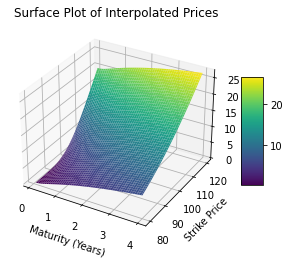

In [7]:
# Creating the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surface = ax.plot_surface(maturity_grid, strike_grid, price_grid, cmap='viridis', edgecolor='none')

# Adding labels and title
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Option Price')
plt.title('Surface Plot of Interpolated Prices')

# Adding a color bar for reference
plt.colorbar(surface, shrink=0.5, aspect=5)

# Display the plot
plt.show()

## 2) LSM <a class="anchor" id="second-bullet"></a>

In [8]:
# Lists to store results
prices_lsm = []
maturity_list_lsm = []
strike_list_lsm = []

# Iterate over each maturity and strike combination
for T in maturities:
    for K in strikes:
        # Initialize the Monte Carlo pricer
        mcpricer = MonteCarloOptionPricing(r, S0, K, T, σ, λ, dim, n, seed)
        # Simulate the asset paths
        mcpricer.GeometricBrownianMotion_vec()
        # Price the option using LSM
        option_price = mcpricer.american_option_LSM(poly_degree, otype='put')[0]

        # Store the results
        prices_lsm.append(option_price)
        maturity_list_lsm.append(T)
        strike_list_lsm.append(K)
        print(f'K/T: {K}/{T}, LSM: {option_price:.4f}')

K/T: 80.0/0.08333333333333333, LSM: 0.0021
K/T: 85.0/0.08333333333333333, LSM: 0.0268
K/T: 90.0/0.08333333333333333, LSM: 0.2020
K/T: 95.0/0.08333333333333333, LSM: 0.9270
K/T: 100.0/0.08333333333333333, LSM: 2.7598
K/T: 105.0/0.08333333333333333, LSM: 5.9483
K/T: 110.0/0.08333333333333333, LSM: 10.1928
K/T: 115.0/0.08333333333333333, LSM: 15.0066
K/T: 120.0/0.08333333333333333, LSM: 20.0020
K/T: 80.0/0.16666666666666666, LSM: 0.0420
K/T: 85.0/0.16666666666666666, LSM: 0.1979
K/T: 90.0/0.16666666666666666, LSM: 0.6867
K/T: 95.0/0.16666666666666666, LSM: 1.8191
K/T: 100.0/0.16666666666666666, LSM: 3.8412
K/T: 105.0/0.16666666666666666, LSM: 6.8624
K/T: 110.0/0.16666666666666666, LSM: 10.7009
K/T: 115.0/0.16666666666666666, LSM: 15.1808
K/T: 120.0/0.16666666666666666, LSM: 20.0036
K/T: 80.0/0.25, LSM: 0.1434
K/T: 85.0/0.25, LSM: 0.4554
K/T: 90.0/0.25, LSM: 1.1787
K/T: 95.0/0.25, LSM: 2.5376
K/T: 100.0/0.25, LSM: 4.6463
K/T: 105.0/0.25, LSM: 7.5864
K/T: 110.0/0.25, LSM: 11.2237
K/T: 115.0

In [9]:
# Convert lists to numpy arrays for processing
maturities_np_lsm = np.array(maturity_list_lsm)
strikes_np_lsm = np.array(strike_list_lsm)
prices_np_lsm = np.array(prices_lsm)

# Creating a grid for maturities and strikes
maturity_grid, strike_grid = np.meshgrid(np.linspace(maturities_np_lsm.min(), maturities_np_lsm.max(), 100),
                                         np.linspace(strikes_np_lsm.min(), strikes_np_lsm.max(), 100))

# Interpolating the prices onto the grid

price_grid = griddata((maturities_np_lsm, strikes_np_lsm), prices_np_lsm, (maturity_grid, strike_grid), method='cubic')

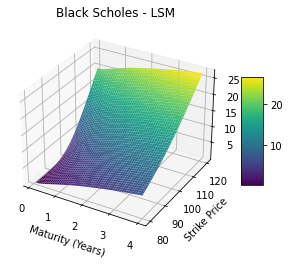

In [10]:
# Creating the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surface = ax.plot_surface(maturity_grid, strike_grid, price_grid, cmap='viridis', edgecolor='none')

# Adding labels and title
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Option Price')
plt.title('Black Scholes - LSM')

# Adding a color bar for reference
plt.colorbar(surface, shrink=0.5, aspect=5)

# Display the plot
plt.show()

## 3) Dynamic Chebyshev <a class="anchor" id="third-bullet"></a>

In [11]:
# Lists to store results
prices_dc = []
maturity_list_dc = []
strike_list_dc = []

# Iterate over each maturity and strike combination
for T in maturities:
    for K in strikes:
        DC_option_pricing = DynamicChebyshev(r, S0, K, T, σ, λ, dim, 32, n_chebyshev_pol, seed, use_AV)
        # a) offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)

        # b) online phase
        DC = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]

        # Store the results
        prices_dc.append(DC)
        maturity_list_dc.append(T)
        strike_list_dc.append(K)
        print(f'K/T: {K}/{T}, D.C.: {DC:.4f}')

K/T: 80.0/0.08333333333333333, D.C.: 0.0000
K/T: 85.0/0.08333333333333333, D.C.: 0.0281
K/T: 90.0/0.08333333333333333, D.C.: 0.2231
K/T: 95.0/0.08333333333333333, D.C.: 0.9820
K/T: 100.0/0.08333333333333333, D.C.: 2.8296
K/T: 105.0/0.08333333333333333, D.C.: 5.9949
K/T: 110.0/0.08333333333333333, D.C.: 10.2037
K/T: 115.0/0.08333333333333333, D.C.: 14.9994
K/T: 120.0/0.08333333333333333, D.C.: 19.9903
K/T: 80.0/0.16666666666666666, D.C.: 0.0451
K/T: 85.0/0.16666666666666666, D.C.: 0.2194
K/T: 90.0/0.16666666666666666, D.C.: 0.7392
K/T: 95.0/0.16666666666666666, D.C.: 1.8981
K/T: 100.0/0.16666666666666666, D.C.: 3.9347
K/T: 105.0/0.16666666666666666, D.C.: 6.9263
K/T: 110.0/0.16666666666666666, D.C.: 10.7481
K/T: 115.0/0.16666666666666666, D.C.: 15.1791
K/T: 120.0/0.16666666666666666, D.C.: 19.9971
K/T: 80.0/0.25, D.C.: 0.1591
K/T: 85.0/0.25, D.C.: 0.5019
K/T: 90.0/0.25, D.C.: 1.2569
K/T: 95.0/0.25, D.C.: 2.6319
K/T: 100.0/0.25, D.C.: 4.7565
K/T: 105.0/0.25, D.C.: 7.6714
K/T: 110.0/0.25,

In [12]:
# Convert lists to numpy arrays for processing
maturities_np_dc = np.array(maturity_list_dc)
strikes_np_dc = np.array(strike_list_dc)
prices_np_dc = np.array(prices_dc)

# Creating a grid for maturities and strikes
maturity_grid, strike_grid = np.meshgrid(np.linspace(maturities_np_dc.min(), maturities_np_dc.max(), 100),
                                         np.linspace(strikes_np_dc.min(), strikes_np_dc.max(), 100))

# Interpolating the prices onto the grid

price_grid = griddata((maturities_np_dc, strikes_np_dc), prices_np_dc, (maturity_grid, strike_grid), method='cubic')

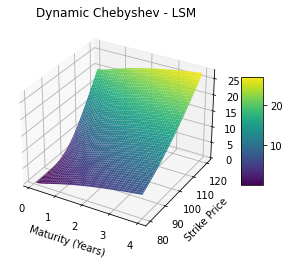

In [13]:
# Creating the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surface = ax.plot_surface(maturity_grid, strike_grid, price_grid, cmap='viridis', edgecolor='none')

# Adding labels and title
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Option Price')
plt.title('Dynamic Chebyshev - LSM')

# Adding a color bar for reference
plt.colorbar(surface, shrink=0.5, aspect=5)

# Display the plot
plt.show()

**Save results:**

In [17]:
# A dictionary to map each list to its corresponding filename
lists_to_save = {
    'prices_fd': prices_fd,
    'maturity_list_fd': maturity_list_fd,
    'strike_list_fd': strike_list_fd,
    'prices_lsm': prices_lsm,
    'maturity_list_lsm': maturity_list_lsm,
    'strike_list_lsm': strike_list_lsm,
    'prices_dc': prices_dc,
    'maturity_list_dc': maturity_list_dc,
    'strike_list_dc': strike_list_dc
}

# Iterating over the dictionary to save each list
for filename, lst in lists_to_save.items():
    with open(f'{filename}.txt', 'w') as file:
        for item in lst:
            file.write("%s\n" % item)

## 4) Error Surface <a class="anchor" id="fourth-bullet"></a>

Open files:

In [98]:
prices_fd

['0.0015716453149271056',
 '0.02537026006800062',
 '0.2034143077812727',
 '0.9322535854531024',
 '2.767211128688668',
 '5.9469685923075035',
 '10.184768959770837',
 '15.001209875479853',
 '20.0',
 '0.040347502885195834',
 '0.19849306478694234',
 '0.6909709071587286',
 '1.8212563575134377',
 '3.8498172153266808',
 '6.852888387063929',
 '10.70194518289486',
 '15.161051169348207',
 '20.001886739888402',
 '0.1424202254870616',
 '0.4618476560691029',
 '1.1885455602309092',
 '2.536318517431279',
 '4.65558902133202',
 '7.5793013442729755',
 '11.2261242971689',
 '15.447658914304045',
 '20.084029924172206',
 '0.6512839554506108',
 '1.3509954180696642',
 '2.4876406812278833',
 '4.152960624389778',
 '6.395844838859114',
 '9.217622838740837',
 '12.579244490411284',
 '16.41527756447391',
 '20.649049685638204',
 '1.242097081140665',
 '2.1854987463379696',
 '3.5412159416094573',
 '5.35833630897252',
 '7.658451857357445',
 '10.43669236571332',
 '13.666770957898324',
 '17.307948688339632',
 '21.3120785

In [64]:
file_path_dc = '../Results/prices_dc.txt'  
file_path_lsm = '../Results/prices_lsm.txt'  
file_path_fd = '../Results/prices_fd.txt'  

with open(file_path_dc, 'r') as file:
    prices_dc = [line.strip() for line in file]
    
with open(file_path_lsm, 'r') as file:
    prices_lsm = [line.strip() for line in file]
    
with open(file_path_fd, 'r') as file:
    prices_fd = [line.strip() for line in file]

In [65]:
file_path_strikes = '../Results/strike_list_lsm.txt'  
file_path_maturity = '../Results/maturity_list_lsm.txt'  

with open(file_path_strikes, 'r') as file:
    strikes = [line.strip() for line in file]
    
with open(file_path_maturity, 'r') as file:
    maturities = [line.strip() for line in file]
    
strikes = [float(item) for item in strikes]
maturities = [float(item) for item in maturities]

In [99]:
maturities = np.array(maturities)
maturities = maturities[:-9]

In [100]:
strikes = np.array(strikes)
strikes = strikes[:-9]

Calculate errors - LSM:

In [68]:
if len(prices_fd) == len(prices_lsm):
    abs_difference_lsm = [abs(float(a) - float(b)) for a, b in zip(prices_fd, prices_lsm)]
else:
    raise ValueError("Lists are of unequal length")

In [101]:
abs_difference_lsm = np.array(abs_difference_lsm)
abs_difference_lsm = abs_difference_lsm[:-9]

Calculate errors DC:

In [70]:
if len(prices_fd) == len(prices_dc):
    abs_difference_dc = [abs(float(a) - float(b)) for a, b in zip(prices_fd, prices_dc)]
else:
    raise ValueError("Lists are of unequal length")

In [102]:
abs_difference_dc = np.array(abs_difference_dc)
abs_difference_dc = abs_difference_dc[:-9]

In [129]:
# Creating a grid for maturities and strikes
maturity_grid, strike_grid = np.meshgrid(np.linspace(maturities.min(), maturities.max(), 8),
                                         np.linspace(strikes.min(), strikes.max(), 8))

# Interpolating the errors onto the grid
error_grid_lsm = griddata((maturities, strikes), abs_difference_lsm, (maturity_grid, strike_grid), method='cubic')

In [130]:
# Interpolating the errors onto the grid
error_grid_dc = griddata((maturities, strikes), abs_difference_dc, (maturity_grid, strike_grid), method='cubic')

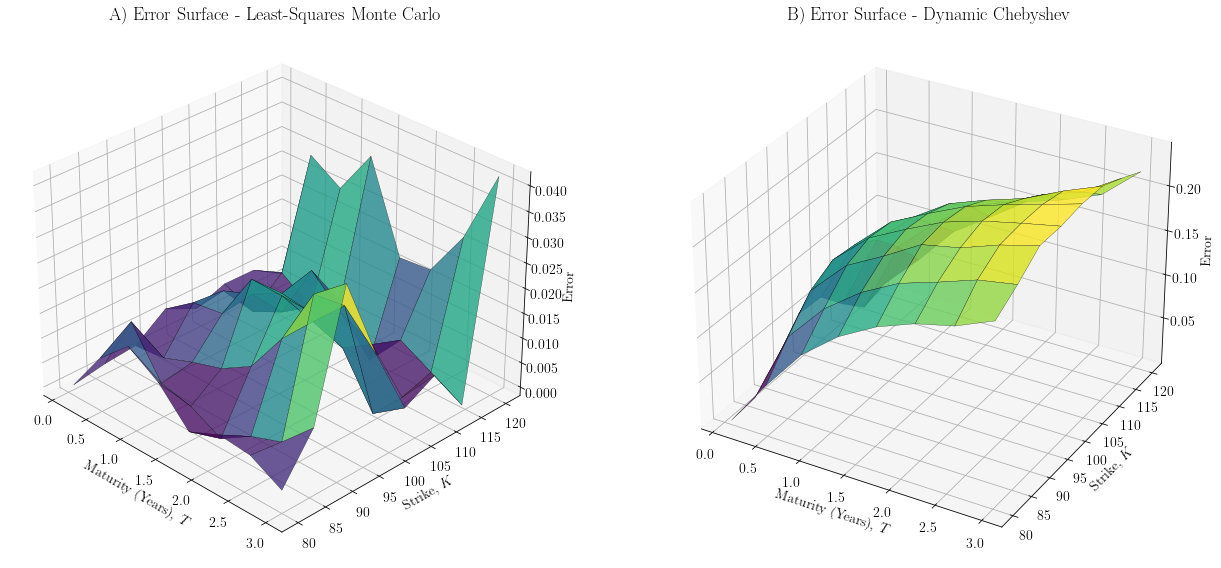

In [169]:
# Create the plot with an optimized figure size
fig = plt.figure(figsize=(20, 8))

# First subplot for LSM
ax1 = fig.add_subplot(121, projection='3d')  # 121 means 1 row, 2 columns, 1st subplot
surface1 = ax1.plot_surface(maturity_grid, strike_grid, error_grid_lsm, cmap='viridis', edgecolor='black', alpha=0.8, linewidth = 0.25)
ax1.set_xlabel('Maturity (Years), $T$', fontsize=14)
ax1.set_ylabel('Strike, $K$', fontsize=14)
ax1.set_zlabel('Error', fontsize=14)
ax1.set_title('A) Error Surface - Least-Squares Monte Carlo', fontsize=18)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='z', labelsize=14)
ax1.view_init(elev=30, azim=-45)
ax1.grid(True, alpha=0.5)

# Second subplot for Dynamic Chebyshev
ax2 = fig.add_subplot(122, projection='3d')  # 122 means 1 row, 2 columns, 2nd subplot
surface2 = ax2.plot_surface(maturity_grid, strike_grid, error_grid_dc, cmap='viridis', edgecolor='black', alpha=0.8, linewidth = 0.25)
ax2.set_xlabel('Maturity (Years), $T$', fontsize=14)
ax2.set_ylabel('Strike, $K$', fontsize=14)
ax2.set_zlabel('Error', fontsize=14)
ax2.set_title('B) Error Surface - Dynamic Chebyshev', fontsize=18)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='z', labelsize=14)
ax1.view_init(elev=30, azim=-45)
ax2.grid(True, alpha=0.5)

fig.subplots_adjust(wspace=0.005)  # Adjust this value as needed

plt.tight_layout()

# Check for directory and save the figure
output_directory = "../Results/plots"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

plt.savefig(f"{output_directory}/ErrorSurface.pdf", bbox_inches='tight')

# Display the plot
plt.show()